In [2]:

!pip install gymnasium


In [3]:
import numpy as np
class Board():
    def __init__(self):
        self.state = np.zeros((6, 7))  # Inicializa un tablero de 6 filas por 7 columnas con ceros (vacío).

    def valid_moves(self):
        return [j for j in range(3) if self.state[0, j] == 0]  # Devuelve una lista de columnas donde la parte superior está vacía, es decir, movimientos válidos.

    def update(self, symbol, col):
        for row in range(5, -1, -1):  # Empieza desde la última fila (inferior) y busca la primera celda vacía.
            if self.state[row, col] == 0:
                self.state[row, col] = symbol  # Coloca el símbolo del jugador en esa celda.
                return row, col  # Devuelve la posición (fila, columna) donde se hizo la actualización.
        raise ValueError("Columna llena!")  # Lanza un error si la columna está llena.

    def is_game_over(self):
        # Verifica si hay un ganador en filas, columnas o diagonales.
        for row in range(6):
            for col in range(7):
                # Verificación de cuatro en línea horizontal
                if col + 3 < 7 and np.all(self.state[row, col:col + 4] == self.state[row, col]) and self.state[row, col] != 0:
                    return self.state[row, col]
                # Verificación de cuatro en línea vertical
                if row + 3 < 6 and np.all(self.state[row:row + 4, col] == self.state[row, col]) and self.state[row, col] != 0:
                    return self.state[row, col]
                # Verificación de diagonal ascendente
                if col + 3 < 7 and row + 3 < 6 and np.all([self.state[row + i, col + i] == self.state[row, col] for i in range(4)]) and self.state[row, col] != 0:
                    return self.state[row, col]
                # Verificación de diagonal descendente
                if col - 3 >= 0 and row + 3 < 6 and np.all([self.state[row + i, col - i] == self.state[row, col] for i in range(4)]) and self.state[row, col] != 0:
                    return self.state[row, col]
        # Si no hay movimientos válidos, es un empate.
        if len(self.valid_moves()) == 0:
            return 0
        # El juego continúa.
        return None

    def reset(self):
        self.state = np.zeros((6, 7))  # Reinicia el tablero.


In [4]:
class Game():
    def __init__(self, player1, player2):
        player1.symbol = 1
        player2.symbol = -1

        self.players = [player1, player2]
        self.board = Board()

    def selfplay(self, rounds=100):
        wins = [0, 0]

        for i in range(1, rounds + 1):
            self.board.reset()

            for player in self.players:
                player.reset()

            game_over = False

            while not game_over:
                for player in self.players:
                    action = player.move(self.board)
                    row, col = self.board.update(player.symbol, action)
                    player.update(self.board)

                    if self.board.is_game_over() is not None:
                        game_over = True
                        break

            self.reward()

            for ix, player in enumerate(self.players):
                if self.board.is_game_over() == player.symbol:
                    wins[ix] += 1

            if i in [500, 1000, 5000]:
                print(f"Iteración {i}: Victorias - Jugador 1: {wins[0]}, Jugador 2: {wins[1]}")

        return wins

    def reward(self):
        winner = self.board.is_game_over()

        if winner == 0:
            for player in self.players:
                player.reward(0.5)
        else:
            for player in self.players:
                if winner == player.symbol:
                    player.reward(1)
                else:
                    player.reward(0)


In [5]:
import numpy as np
import random

class Agent():
    def __init__(self, alpha=0.5, prob_exp=0.3, prob_win=0.7):
        self.value_function = {}
        self.alpha = alpha
        self.positions = []
        self.prob_exp = prob_exp  # Probabilidad de explorar (exploration)
        self.prob_win = prob_win  # Probabilidad de que el agente gane (controla la estrategia)

    def reset(self):
        self.positions = []

    def move(self, board, explore=True):
        valid_moves = board.valid_moves()

        if explore and np.random.uniform(0, 1) < self.prob_exp:
            return random.choice(valid_moves)

        max_value = -1000
        for col in valid_moves:
            next_board = board.state.copy()
            for row in range(5, -1, -1):
                if next_board[row, col] == 0:
                    next_board[row, col] = self.symbol
                    break

            next_state = str(next_board.reshape(6 * 7))
            value = 0 if self.value_function.get(next_state) is None else self.value_function.get(next_state)

            if value >= max_value:
                max_value = value
                best_col = col

        return best_col

    def update(self, board):
        self.positions.append(str(board.state.reshape(6 * 7)))

    def reward(self, reward):
        for p in reversed(self.positions):
            if self.value_function.get(p) is None:
                self.value_function[p] = 0

            self.value_function[p] += self.alpha * (reward - self.value_function[p])
            reward = self.value_function[p]


In [6]:
agent1 = Agent(prob_exp=0.3, prob_win=0.7)
agent2 = Agent(prob_exp=0.7, prob_win=0.3)

game = Game(agent1, agent2)
game.selfplay(1000)


Iteración 500: Victorias - Jugador 1: 80, Jugador 2: 77
Iteración 1000: Victorias - Jugador 1: 137, Jugador 2: 135


[137, 135]

In [7]:
import pandas as pd

funcion_de_valor = sorted(agent1.value_function.items(), key=lambda kv: kv[1], reverse=True)

tabla = pd.DataFrame({
    'estado': [x[0] for x in funcion_de_valor],
    'valor': [x[1] for x in funcion_de_valor]
})

tabla_limited = tabla.head(20)

tabla_limited.style.set_table_styles(
    [{'selector': 'thead th',
      'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
     {'selector': 'tbody td',
      'props': [('text-align', 'center'), ('font-family', 'Arial')]}]
).set_properties(**{'border': '1px solid black', 'border-collapse': 'collapse'}).hide(axis='index')

print(tabla_limited)


                                               estado     valor
0   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.996094
1   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.996094
2   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.996094
3   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.968750
4   [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  ...  0.937500
5   [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  ...  0.875000
6   [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  ...  0.875000
7   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  ...  0.875000
8   [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  ...  0.875000
9   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.750000
10  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.750000
11  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  ...  0.750000
12  [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  ...  0.750000
13  [ 1.  0. -1.  0.  0.  0.  0.  1. -1.  1.  0.  ...  0.750000
14  [ 0.  0. -1.  0.  0.  0.  0.  0.  0.

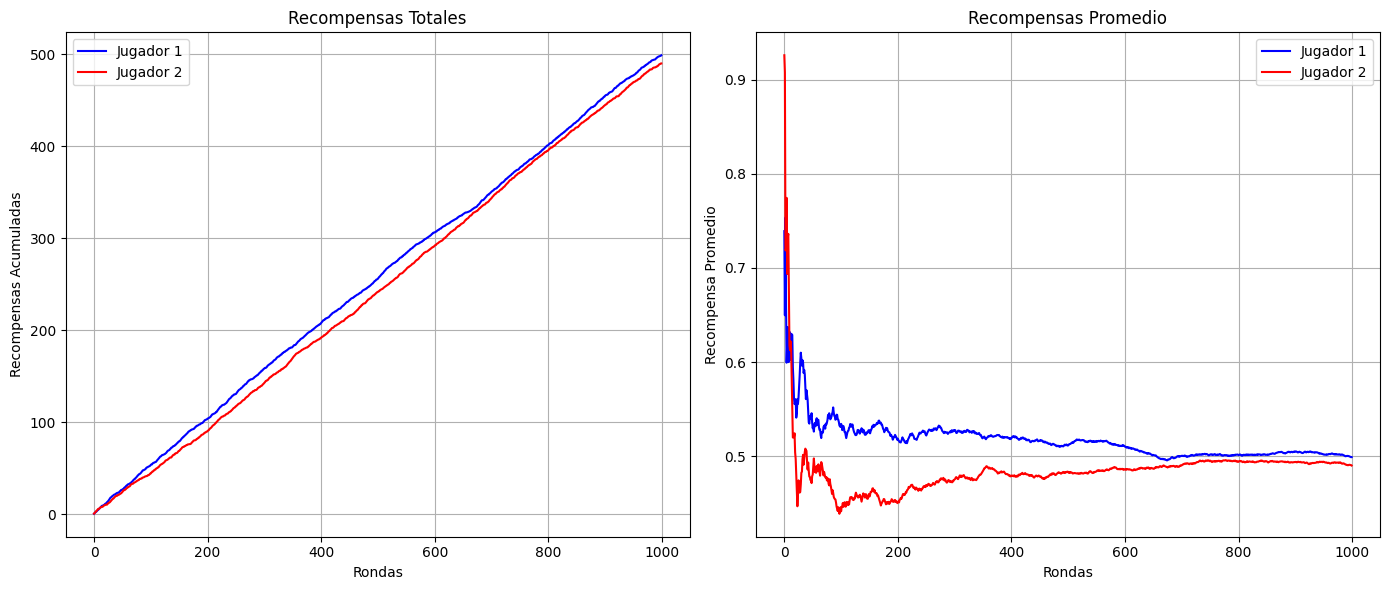

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Datos simulados: asumimos que `total_rewards_p1` y `total_rewards_p2` representan recompensas acumuladas por ronda
# Suponiendo 1000 rondas para los agentes
rounds = 1000
total_rewards_p1 = np.cumsum(np.random.rand(rounds))  # Recompensas acumuladas del jugador 1 (simulado)
total_rewards_p2 = np.cumsum(np.random.rand(rounds))  # Recompensas acumuladas del jugador 2 (simulado)

# Cálculo de las recompensas promedio
average_rewards_p1 = total_rewards_p1 / (np.arange(1, rounds + 1))
average_rewards_p2 = total_rewards_p2 / (np.arange(1, rounds + 1))

# Configurar la visualización de los gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Recompensas Totales
ax1.plot(total_rewards_p1, label="Jugador 1", color='blue')
ax1.plot(total_rewards_p2, label="Jugador 2", color='red')
ax1.set_title("Recompensas Totales")
ax1.set_xlabel("Rondas")
ax1.set_ylabel("Recompensas Acumuladas")
ax1.legend()
ax1.grid(True)

# Gráfico 2: Recompensas Promedio
ax2.plot(average_rewards_p1, label="Jugador 1", color='blue')
ax2.plot(average_rewards_p2, label="Jugador 2", color='red')
ax2.set_title("Recompensas Promedio")
ax2.set_xlabel("Rondas")
ax2.set_ylabel("Recompensa Promedio")
ax2.legend()
ax2.grid(True)

# Mostrar los gráficos
plt.tight_layout()
plt.show()


In [9]:
class AIPlayer:
    def __init__(self, symbol):
        self.symbol = symbol

    def move(self, board):
        valid_moves = board.valid_moves()
        return random.choice(valid_moves)

    def update(self, board):
        pass

    def reset(self):
        pass

    def reward(self, reward_value):
        pass


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def display_board(board_state):
    plt.imshow(board_state, cmap='cool', origin='upper')
    plt.colorbar(ticks=[-1, 0, 1], label='Player')
    plt.xticks(range(7))
    plt.yticks(range(6))
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title('Conecta 4 - Estado del Tablero')
    plt.show()


In [11]:
import numpy as np

class Board():
    def __init__(self):
        self.state = np.zeros((6, 7))  # Tablero de 6 filas y 7 columnas.

    def valid_moves(self):
        return [j for j in range(7) if self.state[0, j] == 0]  # Ahora todas las columnas son válidas

    def update(self, symbol, col):
        for row in range(5, -1, -1):
            if self.state[row, col] == 0:
                self.state[row, col] = symbol
                return row, col
        raise ValueError("Columna llena!")

    def is_game_over(self):
        # Verificaciones de cuatro en línea horizontal, vertical y diagonal.
        for row in range(6):
            for col in range(7):
                if col + 3 < 7 and np.all(self.state[row, col:col + 4] == self.state[row, col]) and self.state[row, col] != 0:
                    return self.state[row, col]
                if row + 3 < 6 and np.all(self.state[row:row + 4, col] == self.state[row, col]) and self.state[row, col] != 0:
                    return self.state[row, col]
                if col + 3 < 7 and row + 3 < 6 and np.all([self.state[row + i, col + i] == self.state[row, col] for i in range(4)]) and self.state[row, col] != 0:
                    return self.state[row, col]
                if col - 3 >= 0 and row + 3 < 6 and np.all([self.state[row + i, col - i] == self.state[row, col] for i in range(4)]) and self.state[row, col] != 0:
                    return self.state[row, col]
        return None  # Si no hay ganador


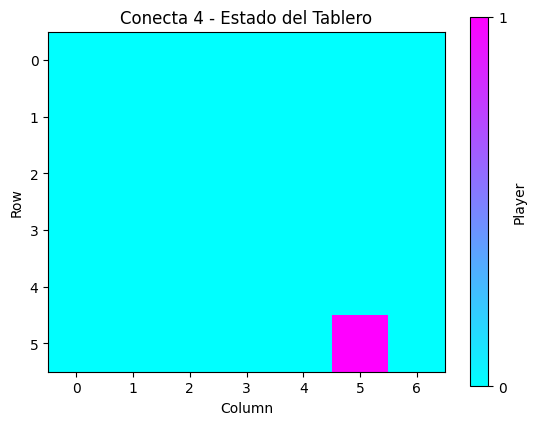

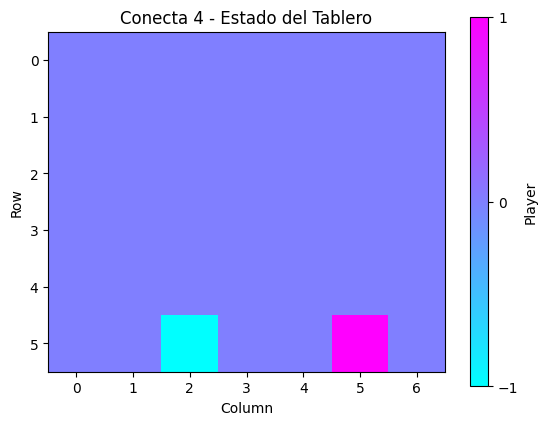

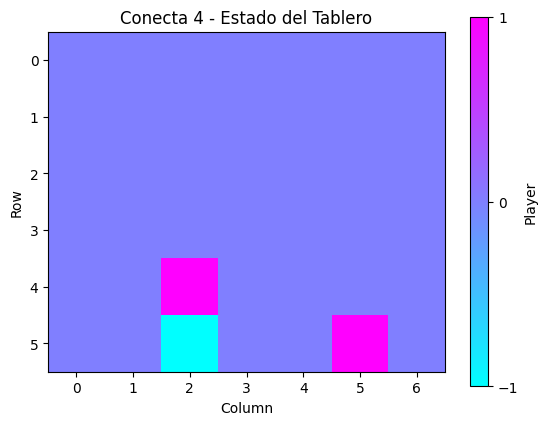

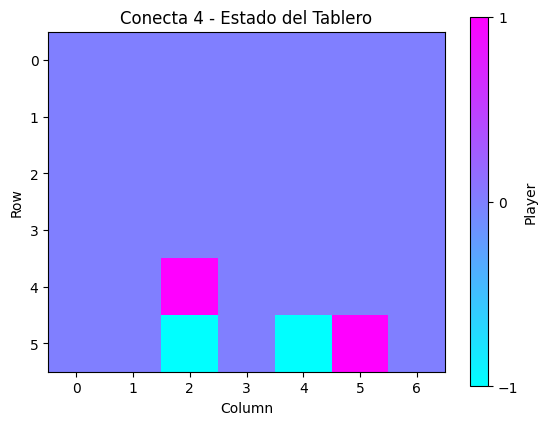

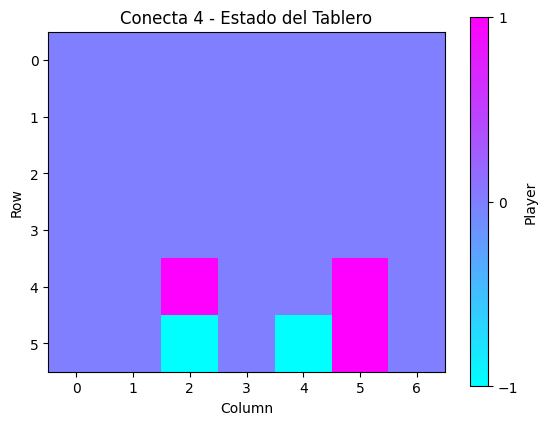

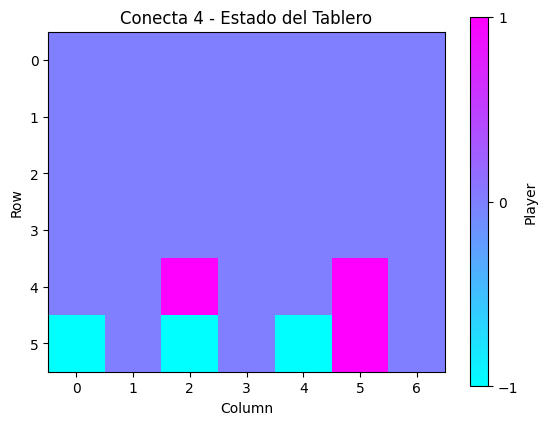

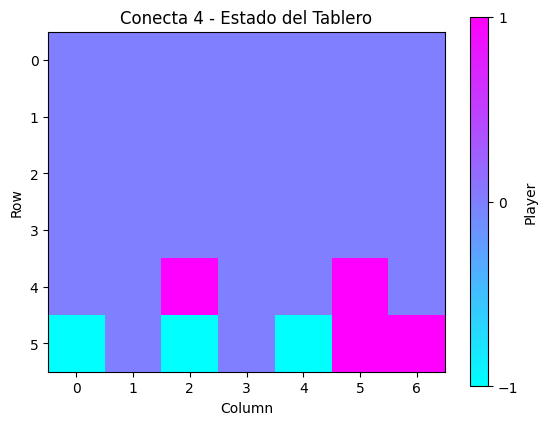

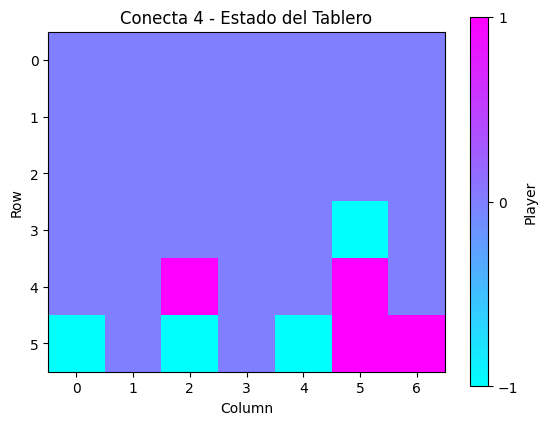

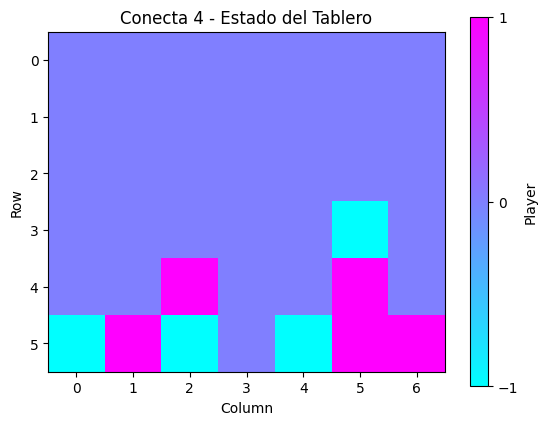

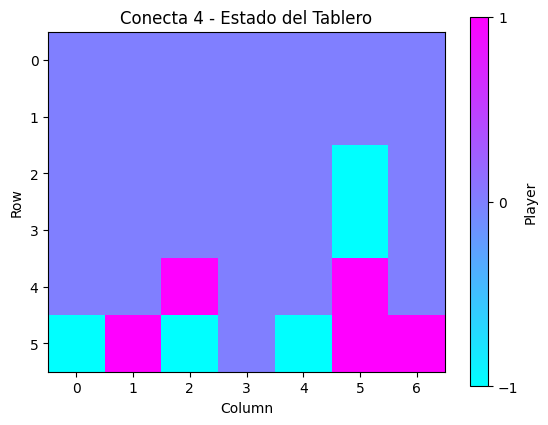

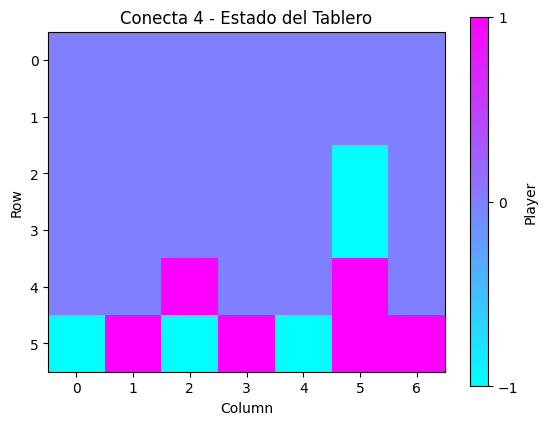

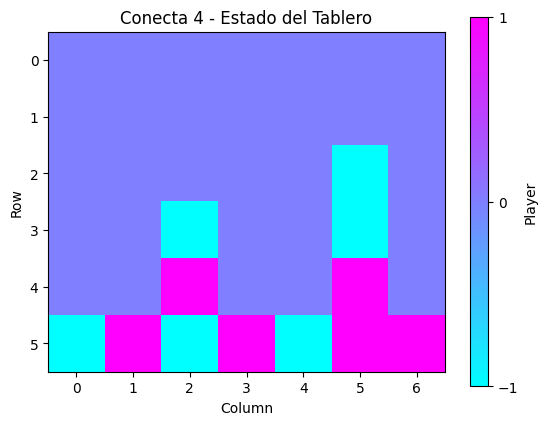

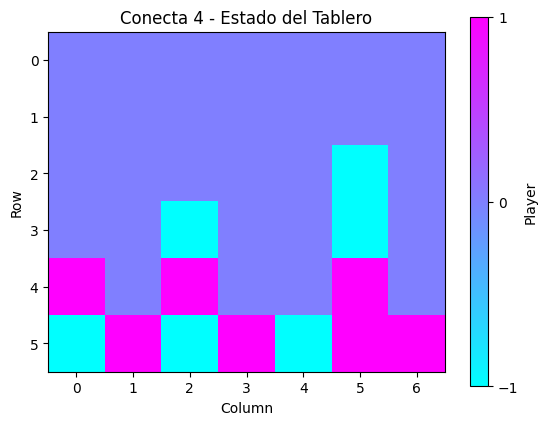

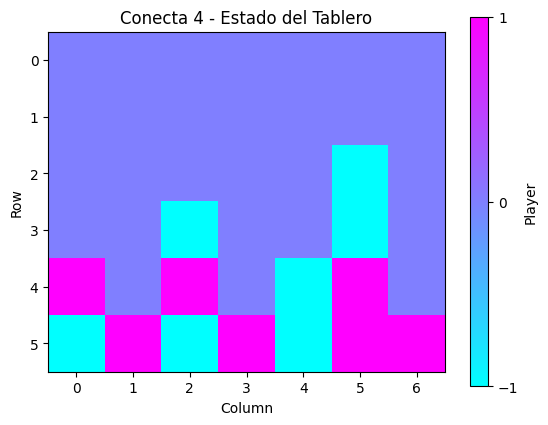

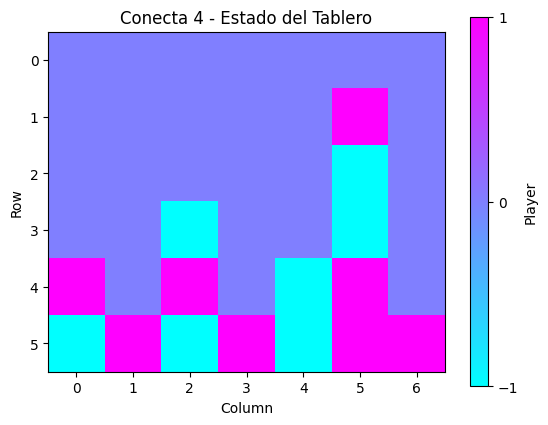

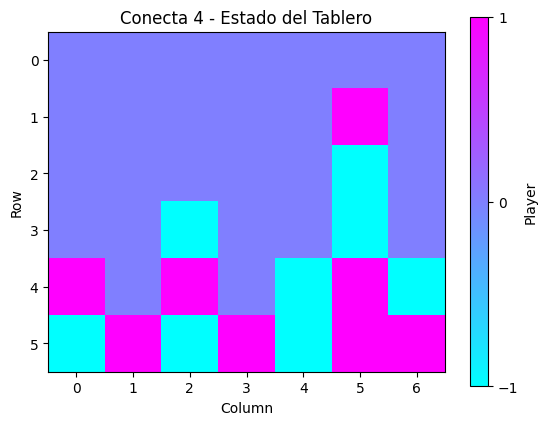

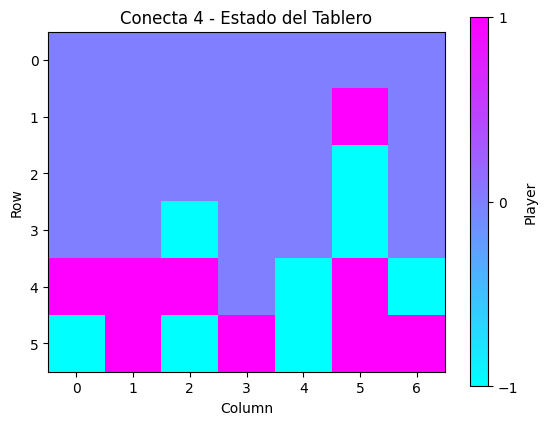

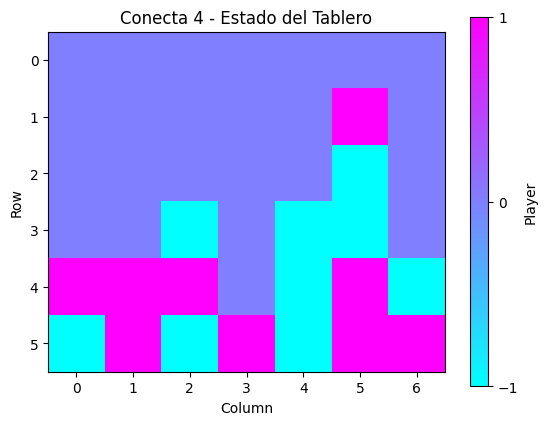

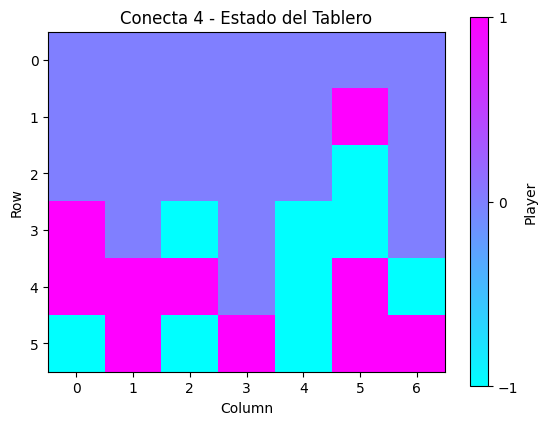

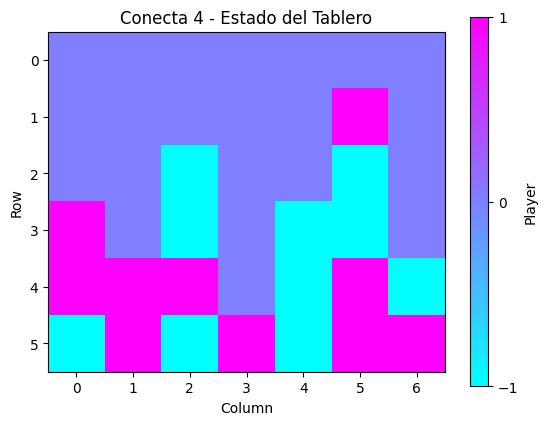

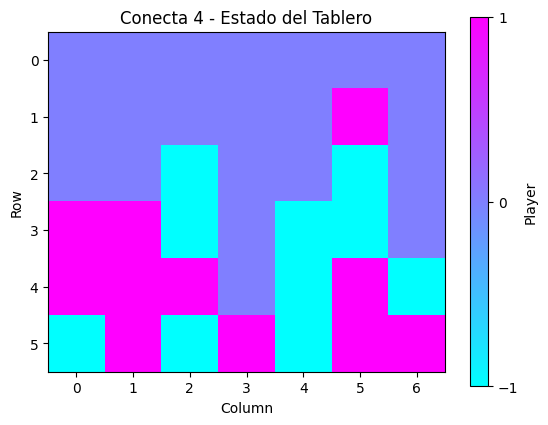

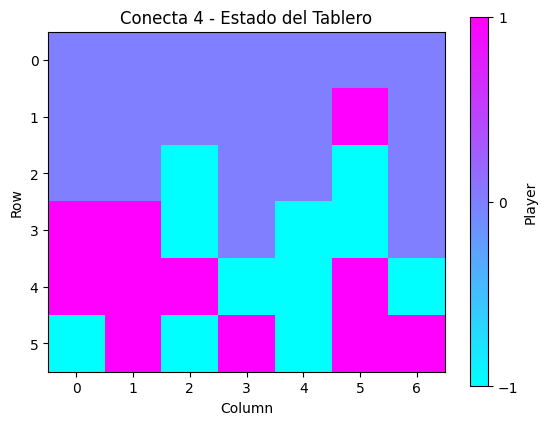

Jugador 2 (IA) gana


In [12]:
# Example of starting a game with a human vs AI setup
player1 = AIPlayer(1)  # AI player
player2 = AIPlayer(-1)  # AI player as opponent for demonstration (can replace with a human player class)

game = Game(player1, player2)


# Simulate a single game between two AI players, displaying the board after each move
game_over = False
while not game_over:
    for player in game.players:
        action = player.move(game.board)
        game.board.update(player.symbol, action)
        display_board(game.board.state)
        if game.board.is_game_over() is not None:
            game_over = True
            break

winner = game.board.is_game_over()
if winner == 0:
    print("Empate")
elif winner == 1:
    print("Jugador 1 (IA) gana")
else:
    print("Jugador 2 (IA) gana")